In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 5
commitnumber = 5014a19
conc = None
dv = 0.001
klin = 2e-20
molecule = o3
ng_adju = [0, 0]
ng_refs = [2, 5]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 300
vmax = 1100
vmin = 980
w_diffuse = [(1.6, 1.75), (1.55, 1.66, 1.7, 1.75, 1.8)]
wgt = [(0.35, 0.6), (0.5, 0.55, 0.7, 0.9, 1.0)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

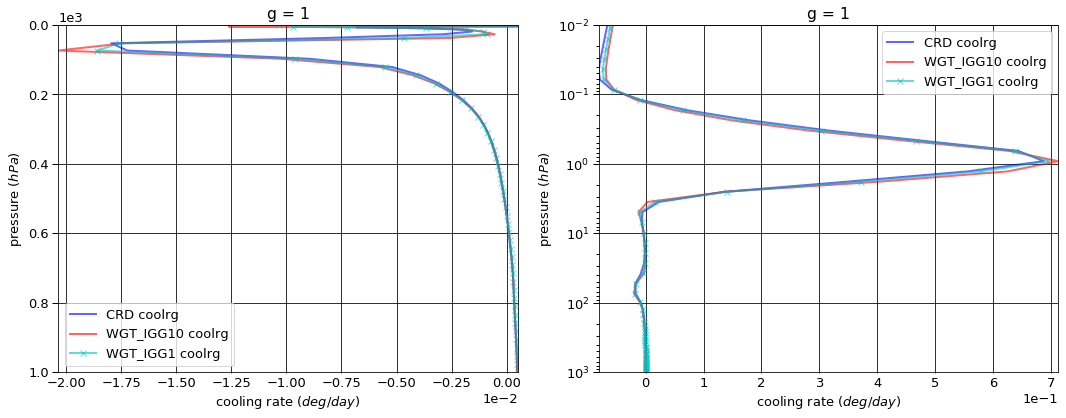

# Figure: cooling rate g-group 2

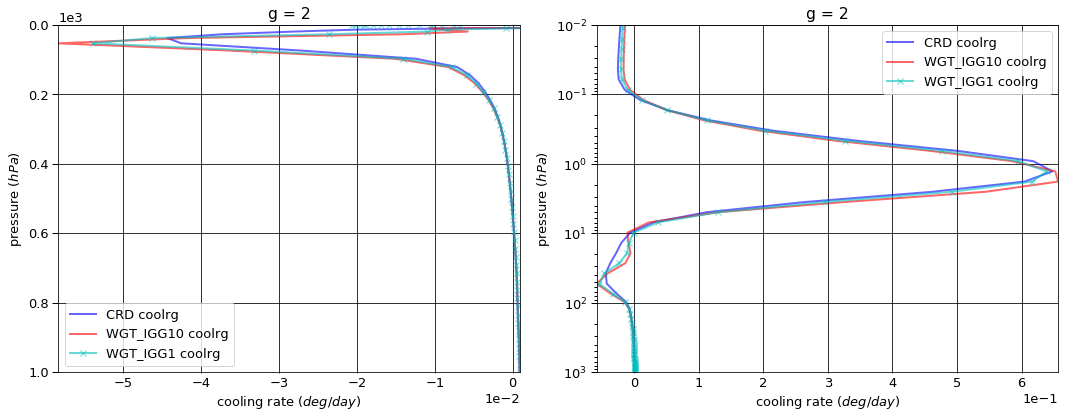

# Figure: cooling rate g-group 3

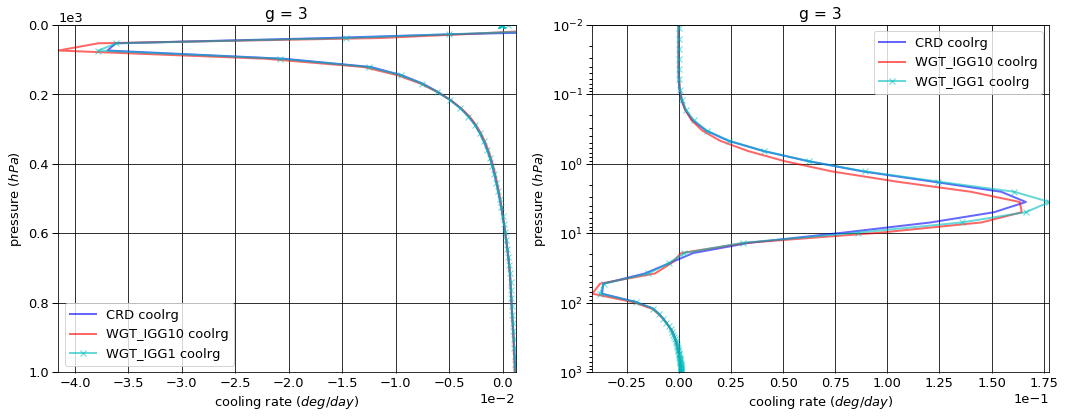

# Figure: cooling rate g-group 4

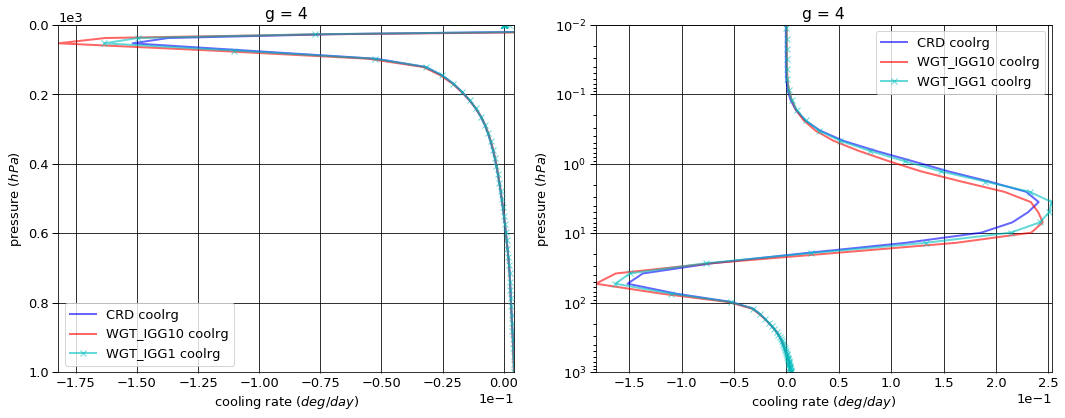

# Figure: cooling rate g-group 5

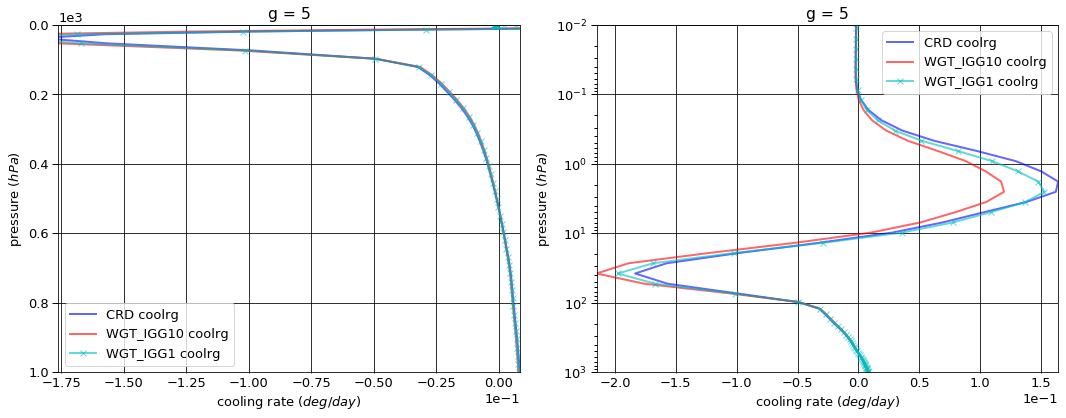

# Figure: cooling rate g-group 6

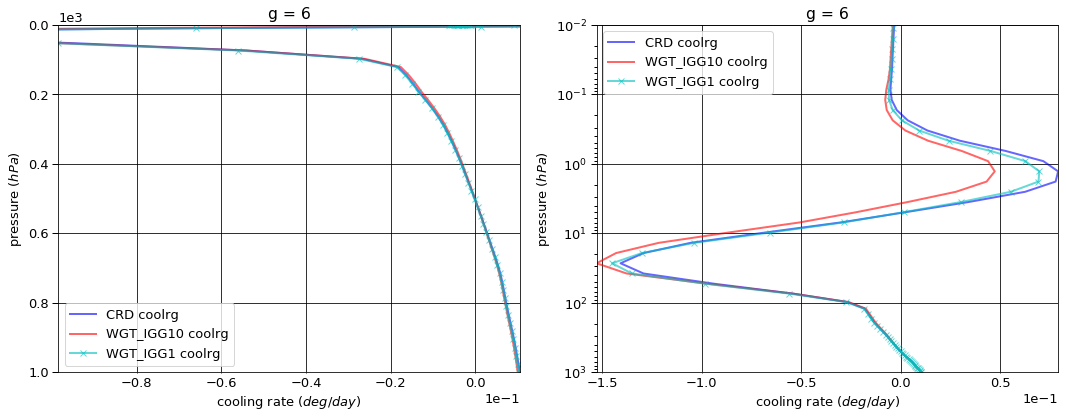

# Figure: cooling rate g-group 7

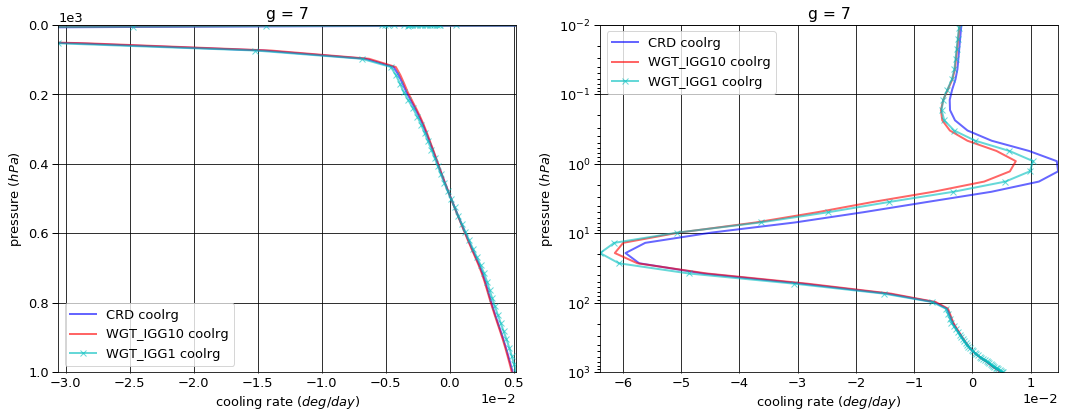

# Figure: cooling rate g-group total

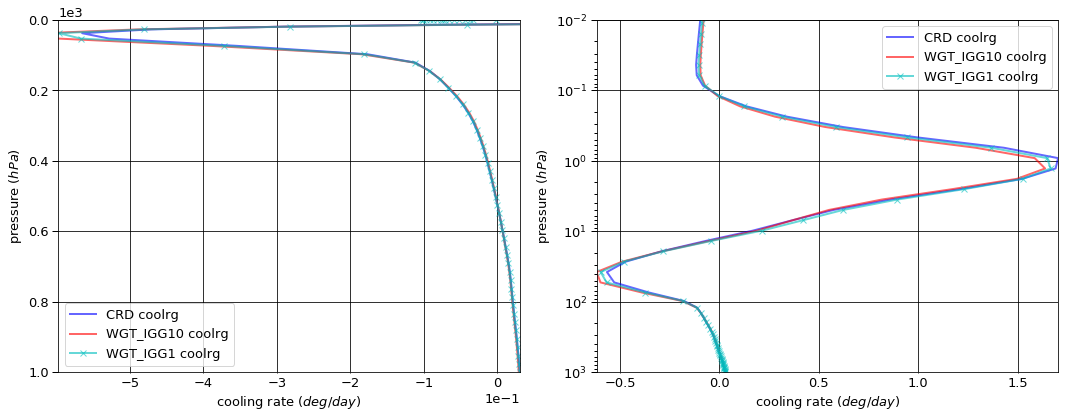

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.112926  0.000000  -0.112926
  1013.0   76     -0.243523  0.071214  -0.172309
2 0.0      1      -0.221286  0.000000  -0.221286
  1013.0   76     -0.539528  0.142600  -0.396927
3 0.0      1      -0.159890  0.000000  -0.159890
  1013.0   76     -0.551525  0.170581  -0.380944
4 0.0      1      -0.626018  0.000000  -0.626018
  1013.0   76     -2.288328  0.630667  -1.657662
5 0.0      1      -2.399464  0.000000  -2.399464
  1013.0   76     -4.923679  1.081433  -3.842246
6 0.0      1      -6.182486  0.000000  -6.182486
  1013.0   76     -8.176602  1.063269  -7.113333
7 0.0      1     -17.309556  0.000000 -17.309556
  1013.0   76    -18.005457  0.414880 -17.590576


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.116278  0.000000  -0.116278
  1013.0   76     -0.243132  0.067507  -0.175626
2 0.0      1      -0.225444  0.000000  -0.225444
  1013.0   76     -0.539973  0.134540  -0.405433
3 0.0      1      -0.161583  0.000000  -0.161583
  1013.0   76     -0.549863  0.159111  -0.390752
4 0.0      1      -0.555756  0.000000  -0.555756
  1013.0   76     -2.285743  0.607963  -1.677780
5 0.0      1      -2.261488  0.000000  -2.261488
  1013.0   76     -4.930311  1.039224  -3.891087
6 0.0      1      -6.190703  0.000000  -6.190703
  1013.0   76     -8.221395  1.019797  -7.201597
7 0.0      1     -17.263594  0.000000 -17.263594
  1013.0   76    -17.958226  0.405621 -17.552605


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.114304  0.000000  -0.114304
  1013.0   76     -0.243132  0.071530  -0.171602
2 0.0      1      -0.221157  0.000000  -0.221157
  1013.0   76     -0.539973  0.138455  -0.401518
3 0.0      1      -0.163640  0.000000  -0.163640
  1013.0   76     -0.549863  0.170918  -0.378945
4 0.0      1      -0.598863  0.000000  -0.598863
  1013.0   76     -2.285743  0.630464  -1.655279
5 0.0      1      -2.376934  0.000000  -2.376934
  1013.0   76     -4.930311  1.053408  -3.876903
6 0.0      1      -6.196714  0.000000  -6.196714
  1013.0   76     -8.221395  1.049243  -7.172152
7 0.0      1     -17.217187  0.000000 -17.217187
  1013.0   76    -17.958226  0.435826 -17.522399


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.003352  0.000000 -0.003352
  1013.0   76     0.000391 -0.003708 -0.003316
2 0.0      1     -0.004158  0.000000 -0.004158
  1013.0   76    -0.000445 -0.008060 -0.008505
3 0.0      1     -0.001693  0.000000 -0.001693
  1013.0   76     0.001662 -0.011471 -0.009808
4 0.0      1      0.070262  0.000000  0.070262
  1013.0   76     0.002585 -0.022704 -0.020119
5 0.0      1      0.137975  0.000000  0.137975
  1013.0   76    -0.006632 -0.042209 -0.048840
6 0.0      1     -0.008217  0.000000 -0.008217
  1013.0   76    -0.044793 -0.043472 -0.088265
7 0.0      1      0.045962  0.000000  0.045962
  1013.0   76     0.047231 -0.009260  0.037971


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001378  0.000000 -0.001378
  1013.0   76     0.000391  0.000316  0.000707
2 0.0      1      0.000129  0.000000  0.000129
  1013.0   76    -0.000445 -0.004146 -0.004591
3 0.0      1     -0.003750  0.000000 -0.003750
  1013.0   76     0.001662  0.000337  0.001999
4 0.0      1      0.027154  0.000000  0.027154
  1013.0   76     0.002585 -0.000202  0.002383
5 0.0      1      0.022529  0.000000  0.022529
  1013.0   76    -0.006632 -0.028025 -0.034656
6 0.0      1     -0.014228  0.000000 -0.014228
  1013.0   76    -0.044793 -0.014026 -0.058819
7 0.0      1      0.092369  0.000000  0.092369
  1013.0   76     0.047231  0.020946  0.068177

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.026169
  1001.112500 75     0.000495
2 0.000312    1     -0.008195
  1001.112500 75     0.000893
3 0.000312    1     -0.000091
  1001.112500 75     0.001195
4 0.000312    1     -0.000269
  1001.112500 75     0.004296
5 0.000312    1     -0.000725
  1001.112500 75     0.008410
6 0.000312    1     -0.001111
  1001.112500 75     0.010506
7 0.000312    1     -0.000603
  1001.112500 75     0.004931


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.021363
  1001.112500 75     0.000478
2 0.000312    1     -0.005641
  1001.112500 75     0.000920
3 0.000312    1     -0.000030
  1001.112500 75     0.001120
4 0.000312    1     -0.000009
  1001.112500 75     0.004109
5 0.000312    1     -0.000639
  1001.112500 75     0.007806
6 0.000312    1     -0.001289
  1001.112500 75     0.010009
7 0.000312    1     -0.000686
  1001.112500 75     0.004867


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.023484
  1001.112500 75     0.000505
2 0.000312    1     -0.006738
  1001.112500 75     0.000923
3 0.000312    1     -0.000059
  1001.112500 75     0.001205
4 0.000312    1     -0.000081
  1001.112500 75     0.004287
5 0.000312    1     -0.000602
  1001.112500 75     0.008098
6 0.000312    1     -0.001192
  1001.112500 75     0.010316
7 0.000312    1     -0.000709
  1001.112500 75     0.005216


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.004806
  1001.112500 75    -0.000017
2 0.000312    1      0.002554
  1001.112500 75     0.000028
3 0.000312    1      0.000062
  1001.112500 75    -0.000074
4 0.000312    1      0.000260
  1001.112500 75    -0.000187
5 0.000312    1      0.000086
  1001.112500 75    -0.000603
6 0.000312    1     -0.000178
  1001.112500 75    -0.000498
7 0.000312    1     -0.000084
  1001.112500 75    -0.000064


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.002685
  1001.112500 75     0.000010
2 0.000312    1      0.001457
  1001.112500 75     0.000031
3 0.000312    1      0.000032
  1001.112500 75     0.000010
4 0.000312    1      0.000188
  1001.112500 75    -0.000009
5 0.000312    1      0.000123
  1001.112500 75    -0.000312
6 0.000312    1     -0.000081
  1001.112500 75    -0.000191
7 0.000312    1     -0.000107
  1001.112500 75     0.000285

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.011626,0.000000,-27.011626
1013.0,76,-34.728642,3.574645,-31.153997



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.774847,0.000000,-26.774847
1013.0,76,-34.728642,3.433762,-31.294880



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.888800,0.000000,-26.888800
1013.0,76,-34.728642,3.549845,-31.178797



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.367793e-01,0.000000,0.236779
1013.0,76,1.800000e-07,-0.140883,-0.140883



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.228257e-01,0.0000,0.122826
1013.0,76,1.800000e-07,-0.0248,-0.024800


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.037163
1001.112500,75,0.030726



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.029657
1001.112500,75,0.029310



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.032866
1001.112500,75,0.030549



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.007506
1001.112500,75,-0.001416



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004297
1001.112500,75,-0.000176


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007008,0.007001
2,0.015458,0.015548
3,0.015917,0.015833
4,0.065800,0.065817
5,0.140908,0.141967
6,0.232192,0.236732
7,0.522717,0.517101


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.107750e-18
2,7.729691e-19
3,1.023108e-18
4,2.756166e-19
5,7.424874e-20
6,2.000197e-20
7,1.116904e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.107750e-18,NaN,0.007008,0.007001,0.007008,0.007001,1.0
2,7.729691e-19,0.151333,0.015458,0.015548,0.022467,0.022549,1.0
3,1.023108e-18,1.323608,0.015917,0.015833,0.038383,0.038382,50.0
4,2.756166e-19,0.269391,0.065800,0.065817,0.104183,0.104200,50.0
5,7.424874e-20,0.269391,0.140908,0.141967,0.245092,0.246166,50.0
6,2.000197e-20,0.269391,0.232192,0.236732,0.477283,0.482899,50.0
7,1.116904e-22,0.005584,0.522717,0.517101,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
